In [1]:
import eaopack as eao
import numpy as np
import datetime as dt
from eaopack.portfolio import Portfolio
from eaopack.basic_classes import Timegrid
from eaopack.optimization import Results

node1 = eao.assets.Node('node_power')
node2 = eao.assets.Node('node_heat')
# heat_demand = np.array()
timegrid = eao.assets.Timegrid(dt.date(2021, 1, 1), dt.date(2021, 1, 2), freq='h', main_time_unit='h')
simple_contract1 = eao.assets.SimpleContract(name='SC_power', price='rand_price_power', nodes=node1,
                                            min_cap=-20., max_cap=20.
                                             )
simple_contract2 = eao.assets.SimpleContract(name='SC_heat', price='rand_price_heat', nodes=node2,
                                            min_cap=-20., max_cap=20
                                             )

chpcontract_1 = eao.assets.CHPContract(name='CHP_1', nodes=[node1, node2],
                                     min_cap=10., max_cap=20.,
                                     extra_costs=0,
                                     freq='h',
                                     # price='rand_price_1',
                                     # min_take={"start": [dt.date(2021, 1, 1)], "end":[dt.date(2021, 2, 1)], "values":[5]},
                                     alpha=0.5, beta=0.5,
                                     ramp=11., start_costs=0., running_costs=0., min_runtime=0,        time_already_running=0
)
chpcontract_2 = eao.assets.CHPContract(name='CHP_2', nodes=[node1, node2],
                                     min_cap=10., max_cap=20.,
                                     extra_costs=0,
                                     freq='h',
                                     # price='rand_price_1',
                                     # min_take={"start": [dt.date(2021, 1, 1)], "end":[dt.date(2021, 2, 1)], "values":[5]},
                                     alpha=0.5, beta=0.5,
                                     ramp=11., start_costs=0., running_costs=0., min_runtime=0,        time_already_running=0
)


prices = {'rand_price_power': np.sin(0.5*np.pi * np.arange(timegrid.T)),
          'rand_price_heat': np.cos(0.5*np.pi * np.arange(timegrid.T)), 
          }

portfolio = eao.portfolio.Portfolio([chpcontract_1, chpcontract_2, simple_contract1, simple_contract2])


In [2]:
op = portfolio.setup_optim_problem(prices, timegrid)
res = op.optimize()
print(res.x)
print(op.mapping)

...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
[ 11.2  20.   10.   -0.    8.8  20.   10.   -0.    8.8  20.   10.   -0.
   8.8  20.   10.   -0.    8.8  20.   10.   -0.    8.8  20.   10.   -0.
   5.6  -0.   -0.   -0.    4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.
   4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.
   1.    1.    1.    0.    1.    1.    1.    0.    1.    1.    1.    0.
   1.    1.    1.    0.    1.    1.    1.    0.    1.    1.    1.    0.
   8.8  -0.   -0.   -0.    8.8  -0.   -0.   -0.    8.8  -0.   -0.   -0.
   8.8  -0.   -0.   -0.    8.8  -0.   -0.   -0.    8.8  -0.   -0.   -0.
   4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.
   4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.    4.4  -0.   -0.   -0.
   1.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
   1.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
 -20.  -20.  -10.    0.  -17.6 -20. 

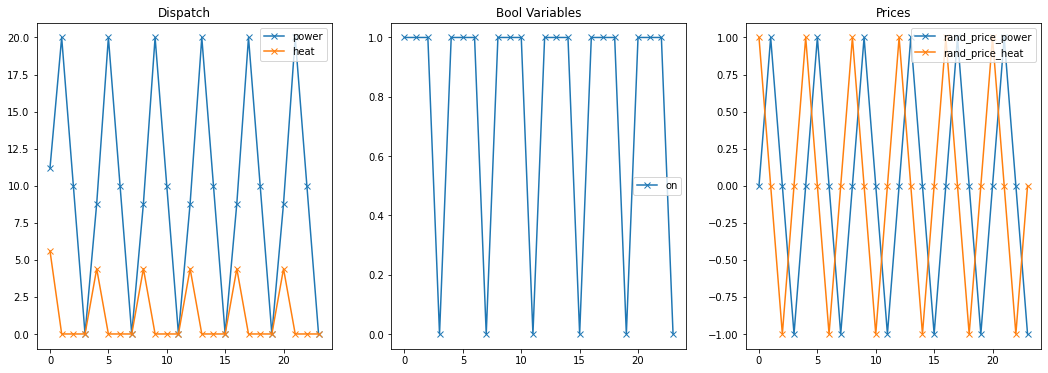

In [4]:
import matplotlib.pyplot as plt

n = timegrid.T
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.title("Dispatch")
plt.plot(res.x[:n], 'x-', label="power")
plt.plot(res.x[n:2*n], 'x-', label="heat")
plt.legend()

plt.subplot(1,3,2)
plt.title("Bool Variables")
plt.plot(res.x[2*n: 3*n], 'x-', label="on")
# plt.plot(res.x[3*n:4*n], label="start")
plt.legend()


plt.subplot(1,3,3)
plt.title("Prices")
for key in prices:
    plt.plot(prices[key], 'x-', label = key)
plt.legend()